# Bunker Prices Prediction 

**Introduction:**

There are different types of crude oil – the thick, unprocessed liquid that drillers extract below the earth – and others are more desirable than others. There are two kinds of Brent, WTI and Dubai/Oman. we need benchmarks to value the commodity based on its quality and location, so I will be using WTI (West Texas Intermediate) for this project.

“Brent” actually refers to oil from four different fields in the North Sea: Brent, Forties, Oseberg and Ekofisk. Crude from this region is light and sweet, making them ideal for the refining of diesel fuel, gasoline.

My Goal is to build a Time Series model to predict bunker price using Brent Crude. With the aid of 20 Major Ports price Average and Brent Crude Datasets, I would explore the relationships between commodities prices and determine the best model.

Nonetheless my main focus of products are VLSFO Fuel Oil and Crude Brent



**Datasets:**
- Avg 20 major Port Bunker price (Shipsandbunker.com)
- Brent Crude Price (Energy Information Administration)

- 20 Major Ports includes:
   - Busan, Colombo, Durban, Fujairah, Gibraltar, Hong Kong, Houston, Istanbul, LA/Long Beach, Las Palmas, Mumbai, New York, Panama, Piraeus, Rotterdam, Santos, Shanghai, Singapore, St Petersburg, Tokyo
  

**Table of content**
  - Part 1: Data Exploration & Cleaning
  - Part 2: Filtering by dates,Differencing variables, Time Series 
  - Part 3: ARIMA
  - Part 4: LSTM
  - Part 5: Conclusion
  

Imports

In [62]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime

import warnings
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
from sklearn.metrics import mean_absolute_percentage_error

Import Data

In [2]:
#import Crude prices
df= pd.read_csv('./data/Daily_Brent2022.csv')

In [3]:
#VLSFO (dated 2020 to 2022 Q1)
#mpa20= pd.read_csv('./data/Daily_Bunker_Prices.csv')

Function for EDA of Data

In [4]:
# Def function for EDA on dataframe
def eda(dataframe):
    print("dataframe shape \n", dataframe.shape, '\n')
    print("dataframe types \n", dataframe.dtypes, '\n')
    print("dataframe describe \n", dataframe.describe(), '\n')
    print("duplicate values \n", dataframe.duplicated().sum(), '\n')
    print("dataframe columns \n", dataframe.columns, '\n')
    
#check if column is unique
    for i in dataframe.columns:
        print('{} is unique: {}'.format(i, dataframe[i].is_unique))

Part 1: Data Exploration

**Brent**

In [5]:
#first 5 row 
df.head()

,Date,Price
0,05/20/1987,18.63
1,05/21/1987,18.45
2,05/22/1987,18.55
3,05/25/1987,18.60
4,05/26/1987,18.63


In [6]:
#apply function for eda
eda(df)

dataframe shape 
 (8815, 2) 

dataframe types 
 Date      object
Price    float64
dtype: object 

dataframe describe 
              Price
count  8815.000000
mean     47.157345
std      32.052617
min       9.100000
25%      18.950000
50%      35.720000
75%      68.415000
max     143.950000 

duplicate values 
 0 

dataframe columns 
 Index(['Date', 'Price'], dtype='object') 

Date is unique: True
Price is unique: False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8815 entries, 0 to 8814
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    8815 non-null   object 
 1   Price   8815 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.9+ KB


In [8]:
df['Price'].value_counts()

18.48    26
18.15    22
16.85    20
18.63    18
17.00    18
         ..
45.54     1
68.53     1
28.83     1
18.76     1
55.06     1
Name: Price, Length: 4867, dtype: int64

In [9]:
#Handling Null Values
df.isnull().any()

Date     False
Price    False
dtype: bool

<AxesSubplot:xlabel='Price', ylabel='Density'>

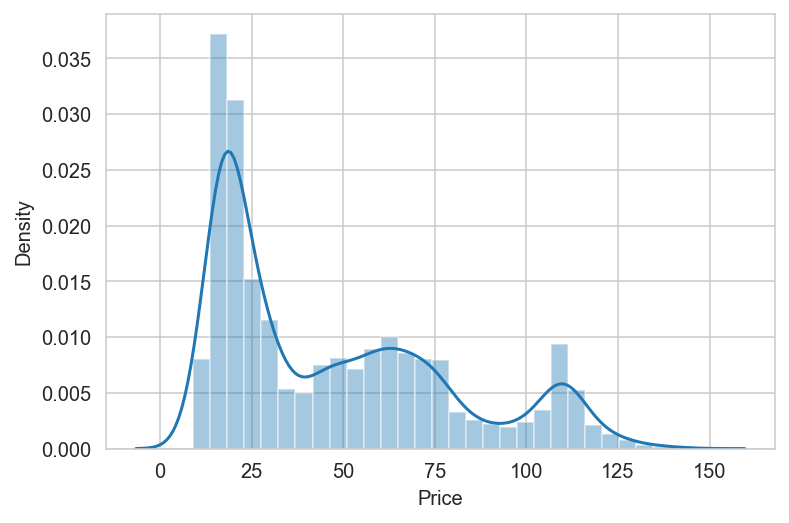

In [10]:
sns.distplot(df['Price'])

Boxplot of Data  

<AxesSubplot:xlabel='Price'>

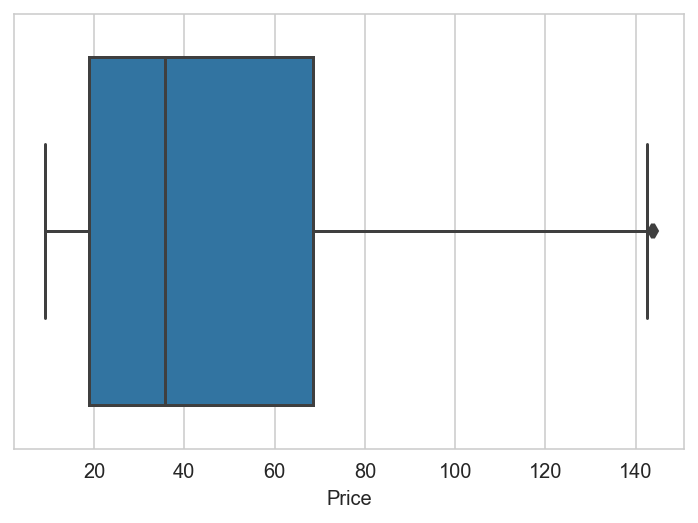

In [11]:
#Box and Whiskers
sns.boxplot(df['Price']) #this we can observe that our outlier is only like a few value

highest being 144 dollars. Q1 around 20 Median and Q3 being 75 

In [12]:
#Convert Date column to be datetime
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [13]:
#setting date to index 
df.index = df.pop('Date')

In [14]:
df.head(3)

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55


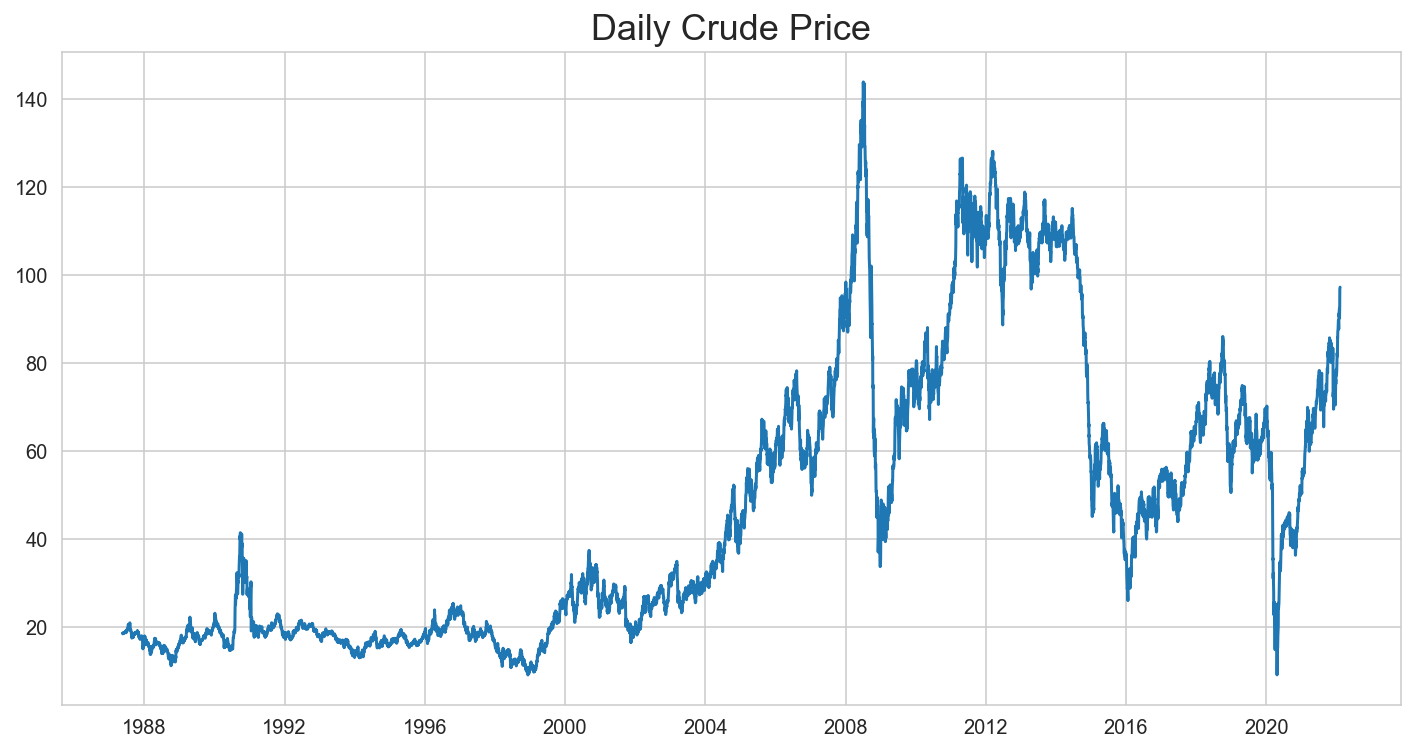

In [15]:
#lets plot our data
#price1= df['Price']
plt.figure(figsize=(12,6))
plt.plot(df['Price'])
plt.title(label = 'Daily Crude Price', fontsize=18)
plt.show();

In [16]:
bin_series = pd.cut(df['Price'],bins = 4).value_counts()
bin_series

(8.965, 42.812]      4717
(42.812, 76.525]     2492
(76.525, 110.237]    1118
(110.237, 143.95]     488
Name: Price, dtype: int64

In [17]:
values = bin_series.to_list()
values

[4717, 2492, 1118, 488]

In [18]:
labels = [str(x) for x in bin_series.index.to_list()]
labels

['(8.965, 42.812]',
 '(42.812, 76.525]',
 '(76.525, 110.237]',
 '(110.237, 143.95]']

Text(0.5, 1.0, 'Distribution of Crude Price')

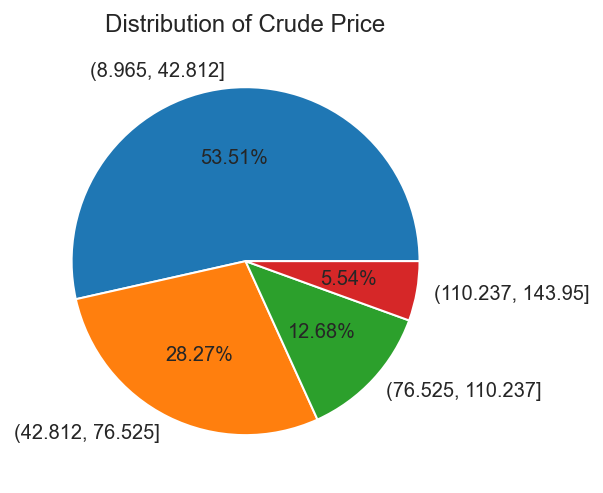

In [19]:
#plot pie chart
plt.pie(values, labels= labels, autopct= '%1.2f%%')
plt.title('Distribution of Crude Price')

Part 2: Filtering by dates,Different time stamps, setting variables

In [20]:
# week average
df1= df.resample('W').mean()
df1.head()

#month average
df2= df.resample('M').mean()
df2.head()

#Year Average
df3=df.resample('Y').mean()
df3.head()

# show all mean in different time stamps
print("Daily avg \n", df.head(), '\n')
print("Weekly avg \n", df1.head(), '\n')
print("Monthly avg \n", df2.head(), '\n')
print("Yearly avg \n", df3.head(), '\n')

Daily avg 
             Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63 

Weekly avg 
                 Price
Date                 
1987-05-24  18.543333
1987-05-31  18.602000
1987-06-07  18.702000
1987-06-14  18.754000
1987-06-21  19.007500 

Monthly avg 
                 Price
Date                 
1987-05-31  18.580000
1987-06-30  18.860476
1987-07-31  19.856522
1987-08-31  18.979524
1987-09-30  18.313182 

Yearly avg 
                 Price
Date                 
1987-12-31  18.525813
1988-12-31  14.905412
1989-12-31  18.228228
1990-12-31  23.761445
1991-12-31  20.041128 



Daily avg 

Weekly avg 

Monthly avg 

Yearly avg 



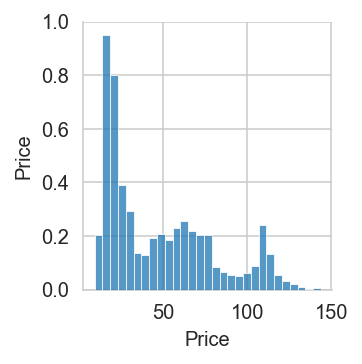

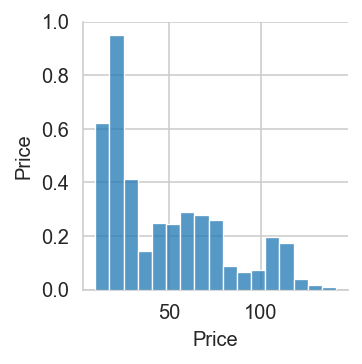

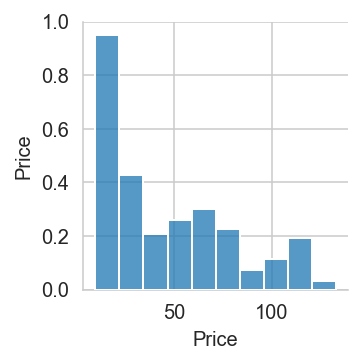

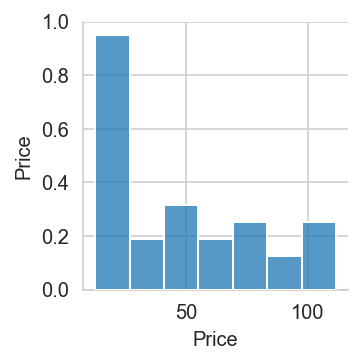

In [21]:
# lot pairplot for all mean
print("Daily avg \n", sns.pairplot(df), '\n')
print("Weekly avg \n", sns.pairplot(df1), '\n')
print("Monthly avg \n", sns.pairplot(df2), '\n')
print("Yearly avg \n", sns.pairplot(df3), '\n')

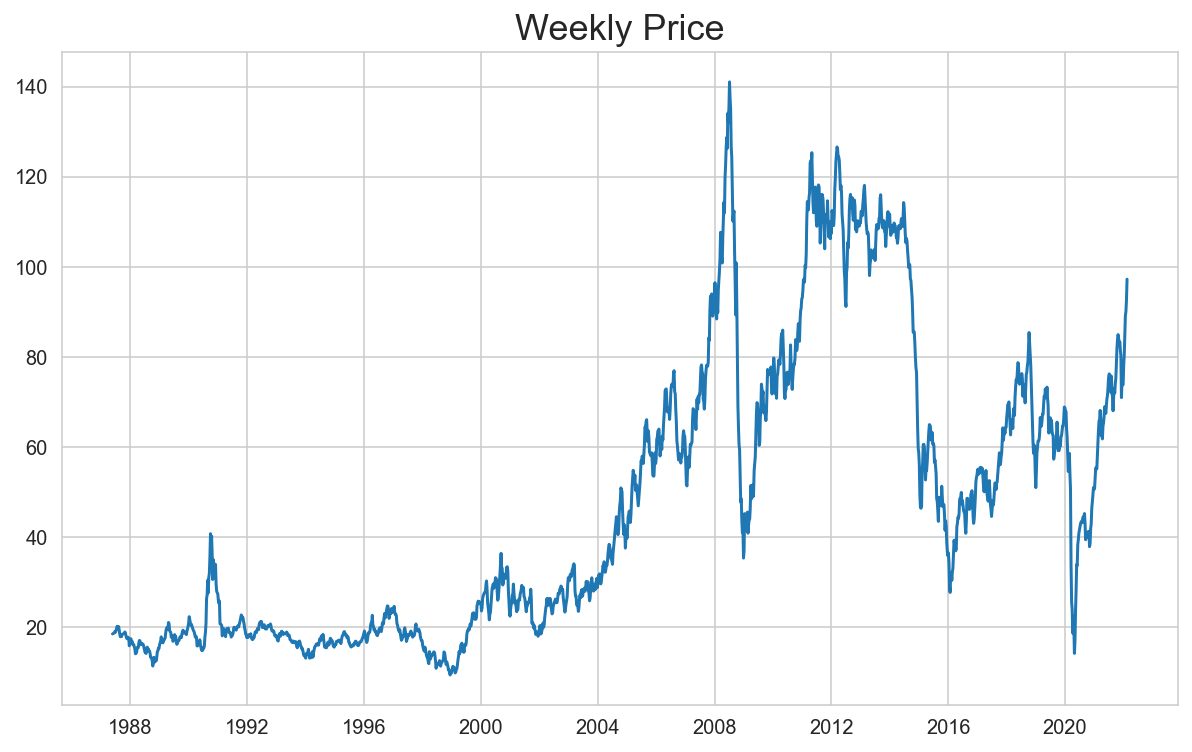

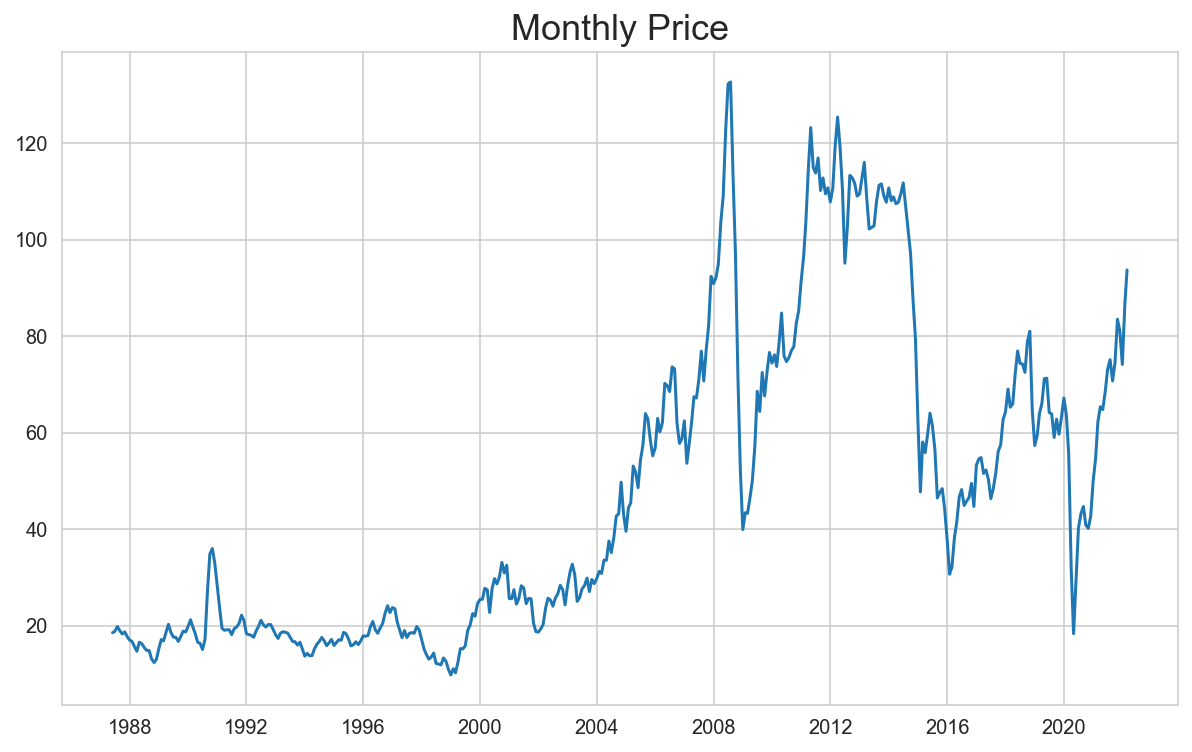

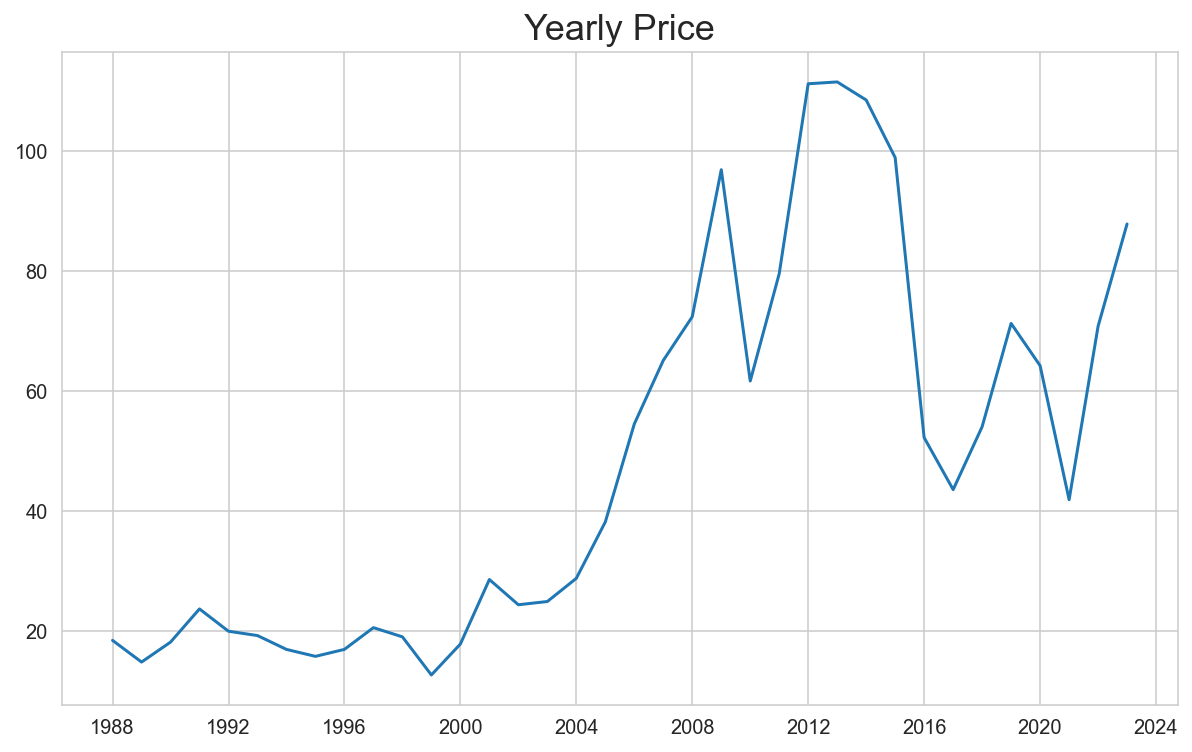

In [22]:
# lets plot our data for diff time stamps
plt.figure(figsize=(10,6))
plt.plot(df1['Price'])
plt.title(label = 'Weekly Price', fontsize=18)
plt.show();

plt.figure(figsize=(10,6))
plt.plot(df2['Price'])
plt.title(label = 'Monthly Price', fontsize=18)
plt.show();

plt.figure(figsize=(10,6))
plt.plot(df3['Price'])
plt.title(label = 'Yearly Price', fontsize=18)
plt.show();

Observation: As the time stamp are seperated into different way of counting , week /month /year
the Plots observe gradually become more gentle curves. Means that when we look at data as year it onyl consider the average of the entire year to a single price point. Hence gentle curve occurs

**20 Major Ports Avg Price**

In [23]:
eda(mpa20)

NameError: name 'mpa20' is not defined

In [ ]:
sns.pairplot(mpa20)

In [ ]:
#preparing data set
mpa20.head()

In [ ]:
mpa20 = mpa20.rename(columns={'VLSFO Fuel Oil, IMO 2020 Grade, 0.5%': 'Price2'})
mpa20.head()

In [ ]:
mpa20['Price2'].value_counts()

In [ ]:
mpa20=mpa20[['Day','Price2']]
mpa20

In [ ]:
#dropping unwanted column
#droplist = ['Month', 'Year','Marine Gas Oil', 'Intermdiate Fuel Oil, 180cSt',
       #'Intermdiate Fuel Oil, 380cSt']
#mpa20_price.drop(droplist, axis = 1, inplace= True)

In [ ]:
mpa20.shape

In [ ]:
mpa20.tail(10)

In [ ]:
mpa20.rename({'Day': 'Date'}, axis=1, inplace=True)
mpa20.head()

In [ ]:
mpa20['Date'] = pd.to_datetime(mpa20['Date'])
mpa20.head()

In [ ]:
#setting date to index 
mpa20.index = mpa20.pop('Date')

In [ ]:
mpa20

***Rolling mean***

In [28]:
#rolling mean for all 10 days
print("Daily avg \n", df.rolling(10).mean(), '\n')
print("Weekly avg \n", df1.rolling(10).mean(), '\n')
print("Monthly avg \n", df2.rolling(10).mean(), '\n')
print("Yearly avg \n", df3.rolling(10).mean(), '\n')

Daily avg 
              Price
Date              
1987-05-20     NaN
1987-05-21     NaN
1987-05-22     NaN
1987-05-25     NaN
1987-05-26     NaN
...            ...
2022-02-01  90.235
2022-02-02  90.414
2022-02-03  90.738
2022-02-04  91.449
2022-02-07  92.403

[8815 rows x 1 columns] 

Weekly avg 
               Price
Date               
1987-05-24      NaN
1987-05-31      NaN
1987-06-07      NaN
1987-06-14      NaN
1987-06-21      NaN
...             ...
2022-01-16  78.2448
2022-01-23  78.8216
2022-01-30  79.6710
2022-02-06  80.9246
2022-02-13  83.5526

[1813 rows x 1 columns] 

Monthly avg 
                 Price
Date                 
1987-05-31        NaN
1987-06-30        NaN
1987-07-31        NaN
1987-08-31        NaN
1987-09-30        NaN
...               ...
2021-10-31  69.290508
2021-11-30  71.918108
2021-12-31  73.107506
2022-01-31  75.217030
2022-02-28  78.112380

[418 rows x 1 columns] 

Yearly avg 
                 Price
Date                 
1987-12-31        NaN
1988-12-3

***300 day Moving Average of Price***

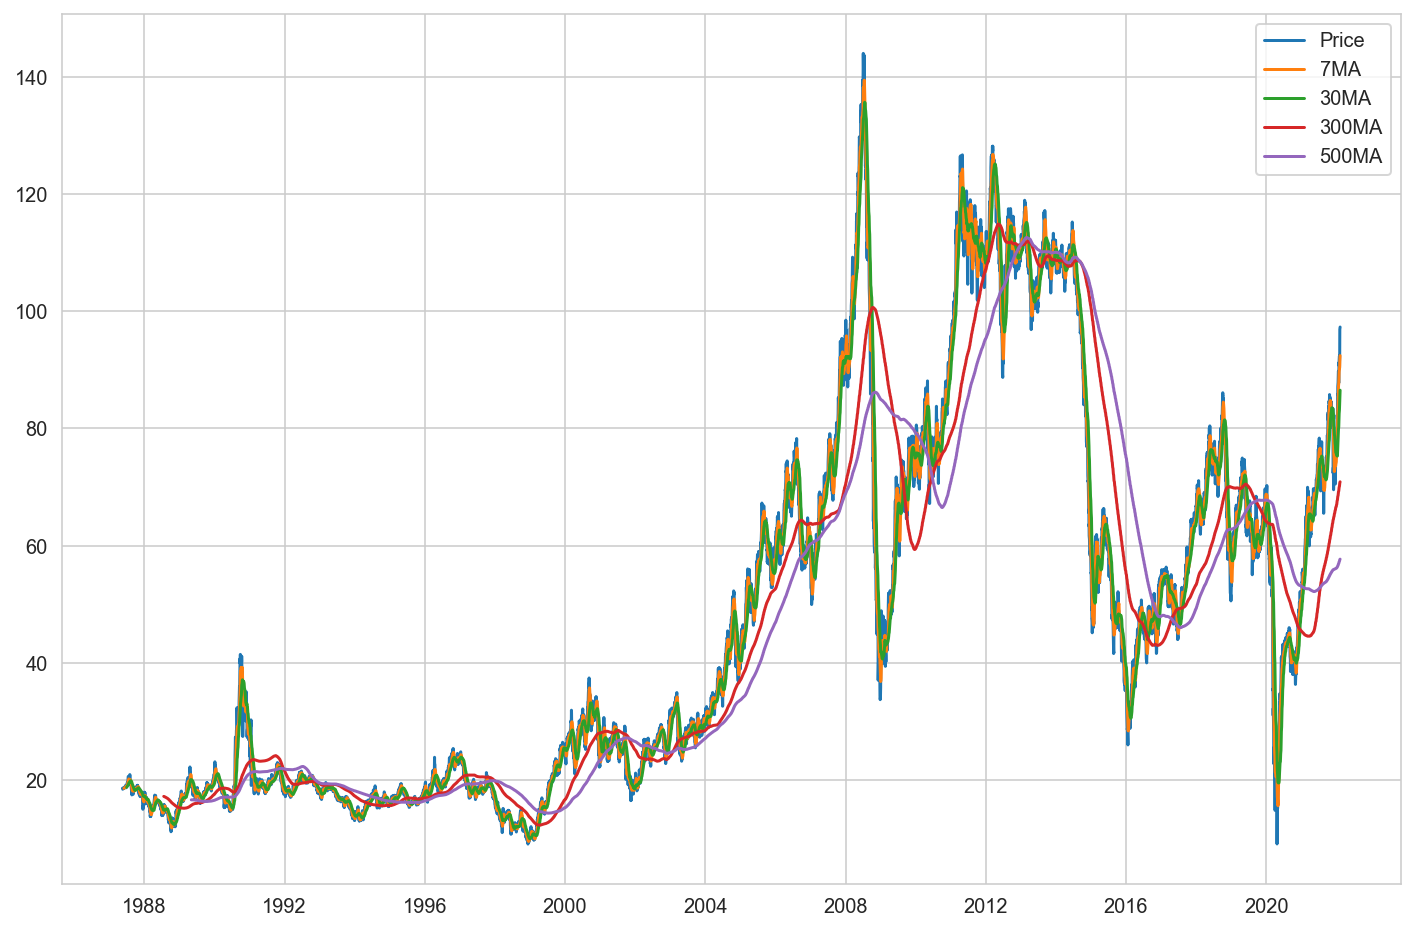

In [23]:
plt.figure(figsize=(12,8))
plt.plot(df['Price'], label='Price')
plt.plot(df['Price'].rolling(10).mean(), label='7MA')
plt.plot(df['Price'].rolling(30).mean(), label='30MA')
plt.plot(df['Price'].rolling(300).mean(), label='300MA')
plt.plot(df['Price'].rolling(500).mean(), label='500MA')
plt.legend();

In [31]:
df2['Price'].rolling(300).mean()

Date
1987-05-31          NaN
1987-06-30          NaN
1987-07-31          NaN
1987-08-31          NaN
1987-09-30          NaN
                ...    
2021-10-31    57.766436
2021-11-30    57.960737
2021-12-31    58.128696
2022-01-31    58.338588
2022-02-28    58.581619
Freq: M, Name: Price, Length: 418, dtype: float64

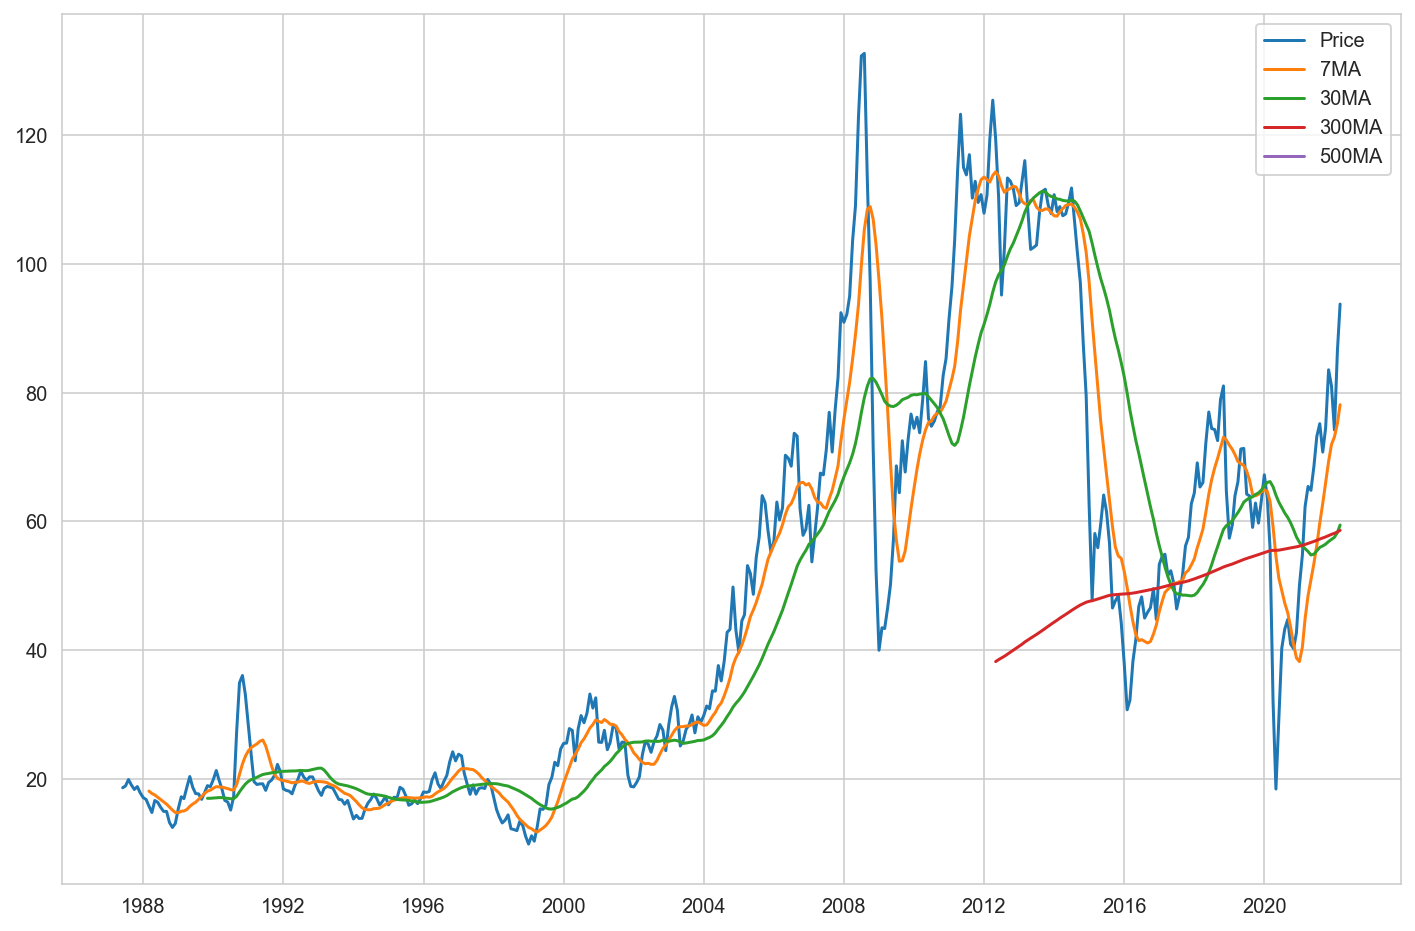

In [24]:
#lets see Monthly Moving average
plt.figure(figsize=(12,8))
plt.plot(df2['Price'], label='Price')
plt.plot(df2['Price'].rolling(10).mean(), label='7MA')
plt.plot(df2['Price'].rolling(30).mean(), label='30MA')
plt.plot(df2['Price'].rolling(300).mean(), label='300MA')
plt.plot(df2['Price'].rolling(500).mean(), label='500MA')
plt.legend();

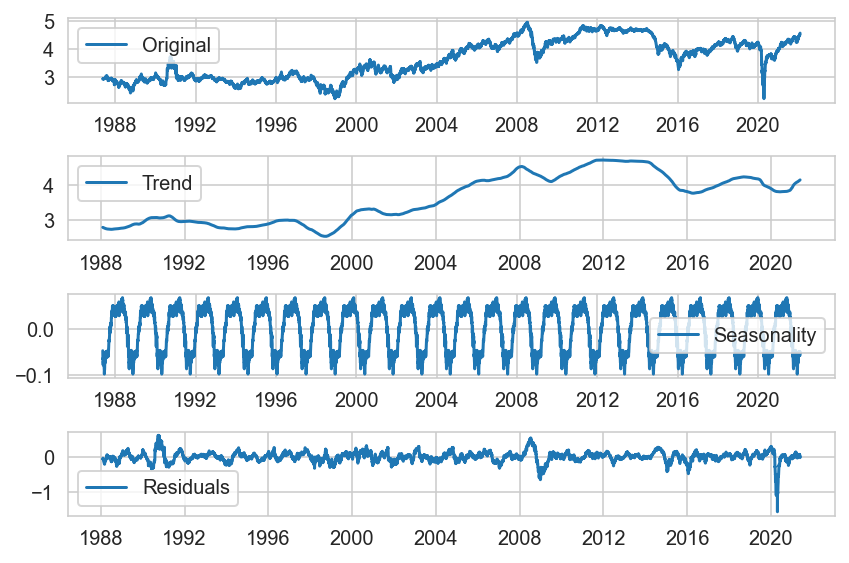

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_log = np.log(df['Price'])

decomposition = seasonal_decompose(ts_log, freq = 365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

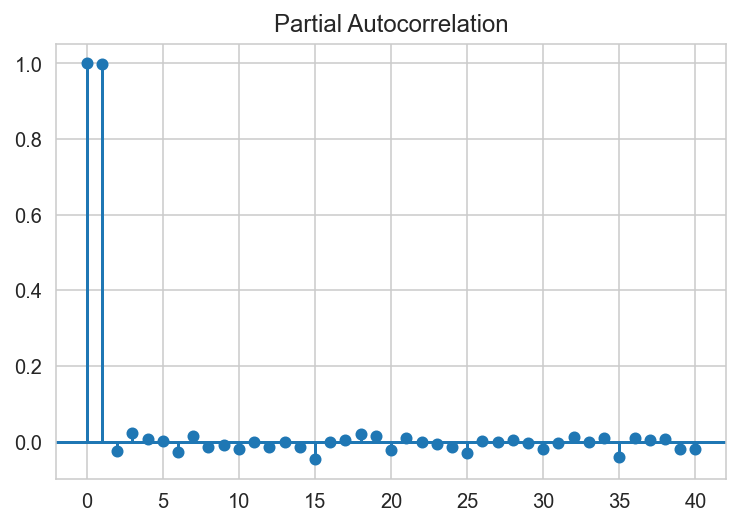

In [33]:
# 3.Stationarity of Data, Using Pacf to determine what order have best corr 
import pmdarima as pm
from pmdarima import datasets

y = df['Price']
pm.plot_pacf(y)

In [34]:
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(df['Price'], autolag= 'AIC')

In [35]:
print(' ADF:',adftest[0])
print('P-value:',adftest[1])
print('Num of lags:',adftest[2])
print('Num of Observation used for ADF Regression & Critical value Calculation:',adftest[3])
print('Critical value:')
for key, val in adftest[4].items():
    print('\t' ,key, ":", val)

 ADF: -1.8997715641726658
P-value: 0.33216858177501096
Num of lags: 35
Num of Observation used for ADF Regression & Critical value Calculation: 8779
Critical value:
	 1% : -3.43109509774388
	 5% : -2.8618692838372026
	 10% : -2.566945272806482


Observation: p-value = 0.3 > 0.05, means dataset is not stationary ,differencing needed

In [ ]:
#import ADF
from pmdarima.arima.stationarity import ADFTest

# Augmented Dickey-Fuller test 
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df['Price'])

Since the ADF test show 'True' meaning dataset should do differencing

In [36]:
#Estimating d parameter more directly
from pmdarima.arima.utils import ndiffs
n_kpss = ndiffs(y, test='kpss')  # -> 0
n_kpss #integration order of the seasonal process=1

1

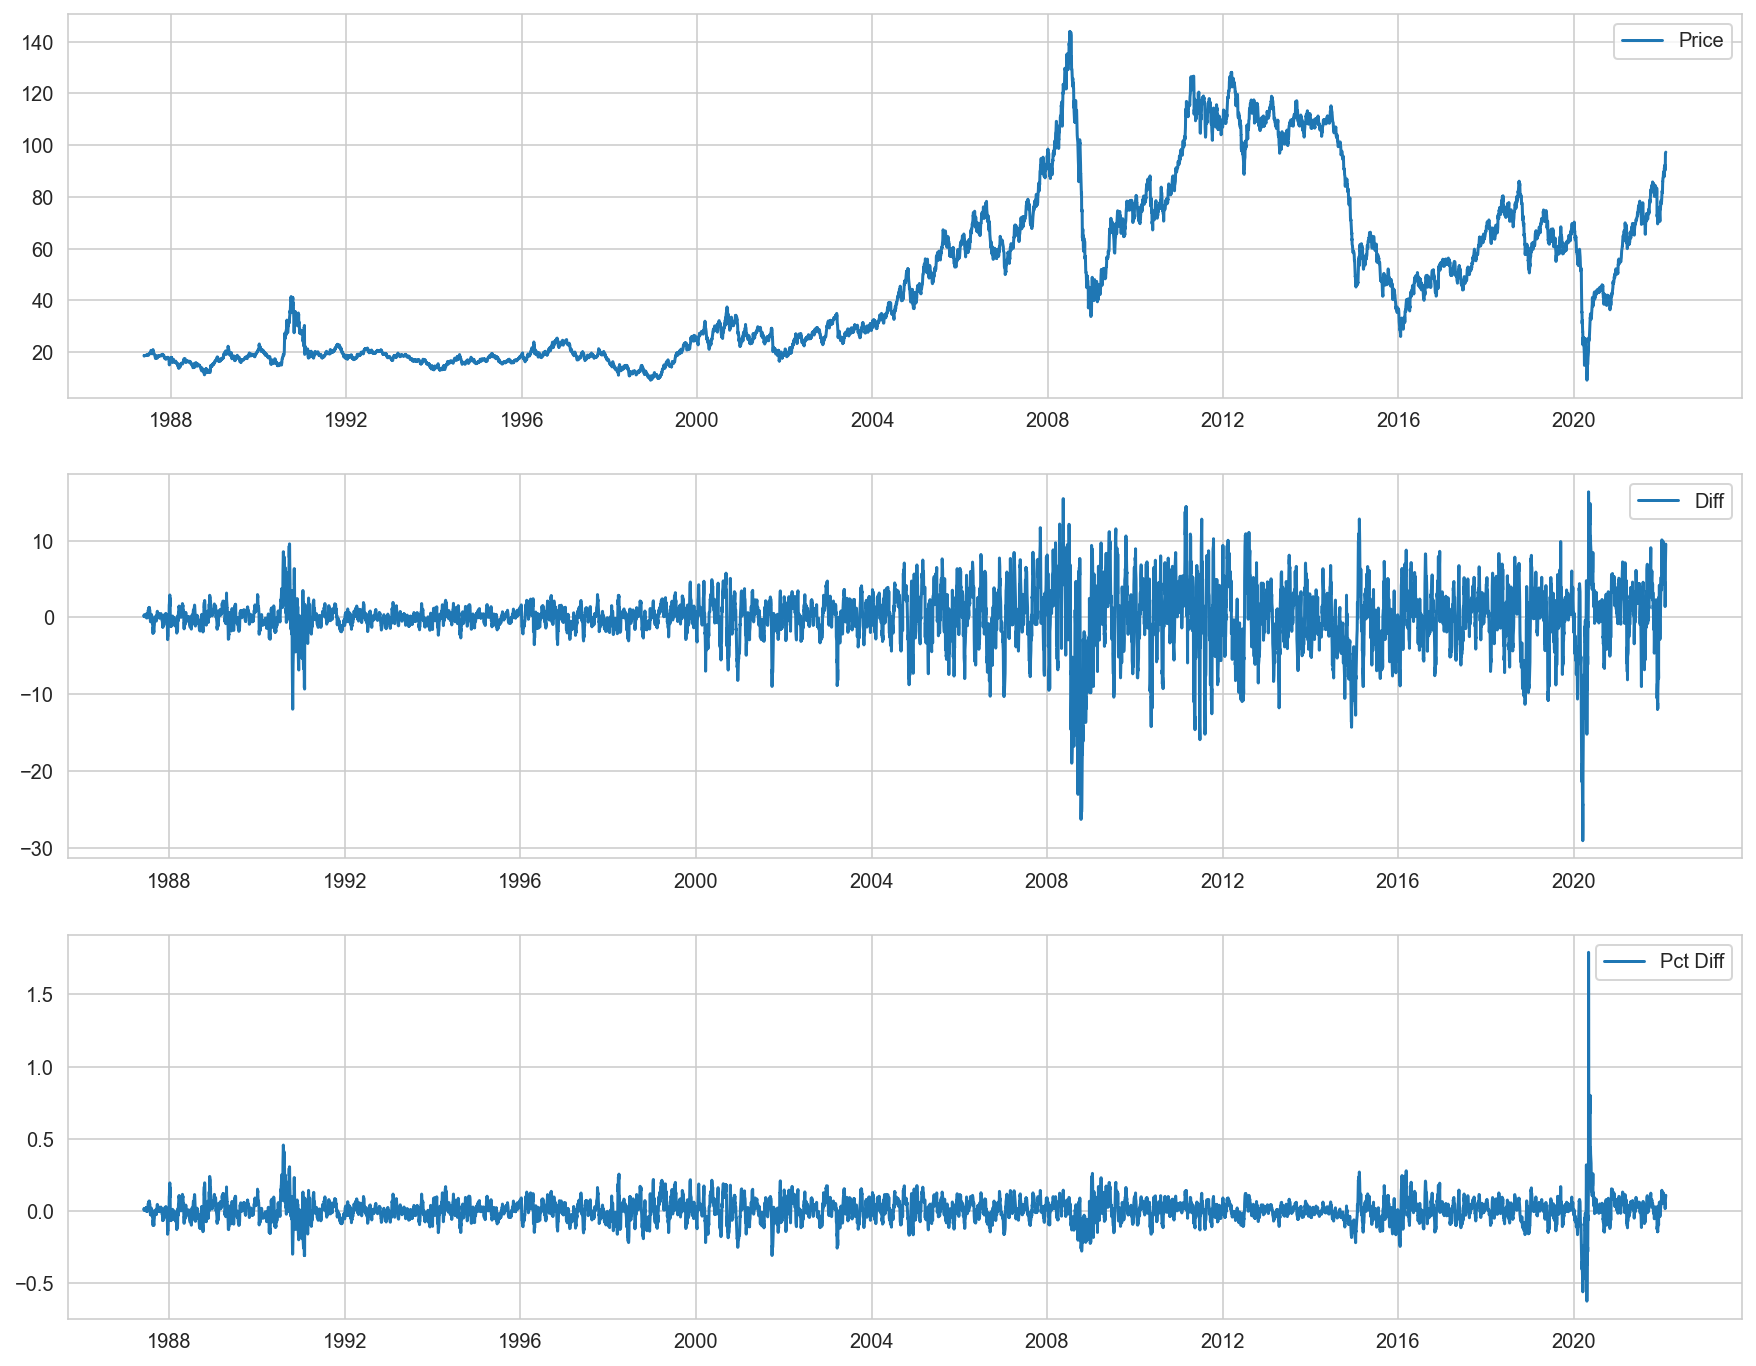

In [37]:
#Applying Differencing to Data
df_diff = df.diff(10)
df_diff.tail()

df_pct = df.pct_change(10)
df_pct.tail()

#comparing plots
fig, axes = plt.subplots(nrows=3, figsize=(15,12))
axes[0].plot(df['Price'], label='Price')
axes[0].legend()
axes[1].plot(df_diff, label='Diff')
axes[1].legend()
axes[2].plot(df_pct, label='Pct Diff')
axes[2].legend()

In [47]:
# def function to plot data
def plot_series(df, col, title='Title', xlab=None, ylab=None, steps=1):
    
    plt.figure(figsize=(17,8))
               
    plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=25)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [51]:
# Create train-test split.
y_train = df['2000': '2007']


In [52]:
y_test = df['2008']

In [53]:
print(df.shape)
print(y_train.shape,y_test.shape)

(8815, 1)
(2046, 1) (253, 1)


In [54]:
y_test.tail()

,Price
Date,
2008-12-24,34.45
2008-12-26,33.73
2008-12-29,34.16
2008-12-30,35.22
2008-12-31,35.82


we will be using 2000 to 2007 as train , 2008 as test data 

In [55]:
#more imports
from sklearn.model_selection import train_test_split
import pmdarima as pm

In [56]:
# Fit Auto ARIMA
arima_model = pm.AutoARIMA(start_p=0, max_p=4, 
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=4,
                           start_P=0, max_P=4,
                           D=None,
                           start_Q=0, max_Q=4,
                           m=12, # For monthly data since the pattern repeats every 12 months
                           seasonal=True,
                           trace=True, # Print values for each fit in the grid search
                           random=True,
                           #random_state=20,
                           n_fits=50
                          )

arima_model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5546.136, Time=0.30 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5548.524, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5548.614, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5546.836, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=5546.554, Time=0.25 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=5546.644, Time=0.26 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=5548.051, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=5548.096, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5548.098, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5542.902, Time=0.86 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=5549.737, Time=1.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=5549.818, Time=1.04 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=5551.305, Time=1.62 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=5550.518, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0

AutoARIMA(m=12, max_P=4, max_Q=4, max_p=4, max_q=4, n_fits=50, random=True,
          start_P=0, start_Q=0, start_p=0, start_q=0, trace=True)

In [57]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2046
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2767.451
Date:                Sat, 09 Apr 2022   AIC                           5542.902
Time:                        08:01:37   BIC                           5565.395
Sample:                             0   HQIC                          5551.152
                               - 2046                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0680      0.041      1.646      0.100      -0.013       0.149
ar.L1         -0.9954      0.007   -150.194      0.000      -1.008      -0.982
ma.L1          0.9887      0.009    112.205      0.000       0.971       1.006
sigma2         0.8769      0.019     45.993      0.000       0.839       0.914
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               409.37
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
# Create an helper function to help make predictions and plot the results
def plot_forecast(y_train, y_test, arima_model, X_test=None):
    # Generate len(y_test) number of predictions
    y_pred1 = arima_model.predict(n_periods = len(y_test), X=X_test)

    # Plot data.
    plt.figure(figsize=(10,6))

    # Plot training data.
    plt.plot(y_train, color='blue', label='y_train')

    # Plot testing data.
    plt.plot(y_test, color='orange', label='y_test')

    # Plot predicted test values.
    plt.plot(y_test.index, y_pred1, color='green', label='y_pred')
    
    # Find the MAPE of the predictions
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html
    mape = mean_absolute_percentage_error(y_test, y_pred)

    plt.title(label = f'Price Predictions\n MAPE: {mape:.2f}', fontsize=16)
    plt.legend();

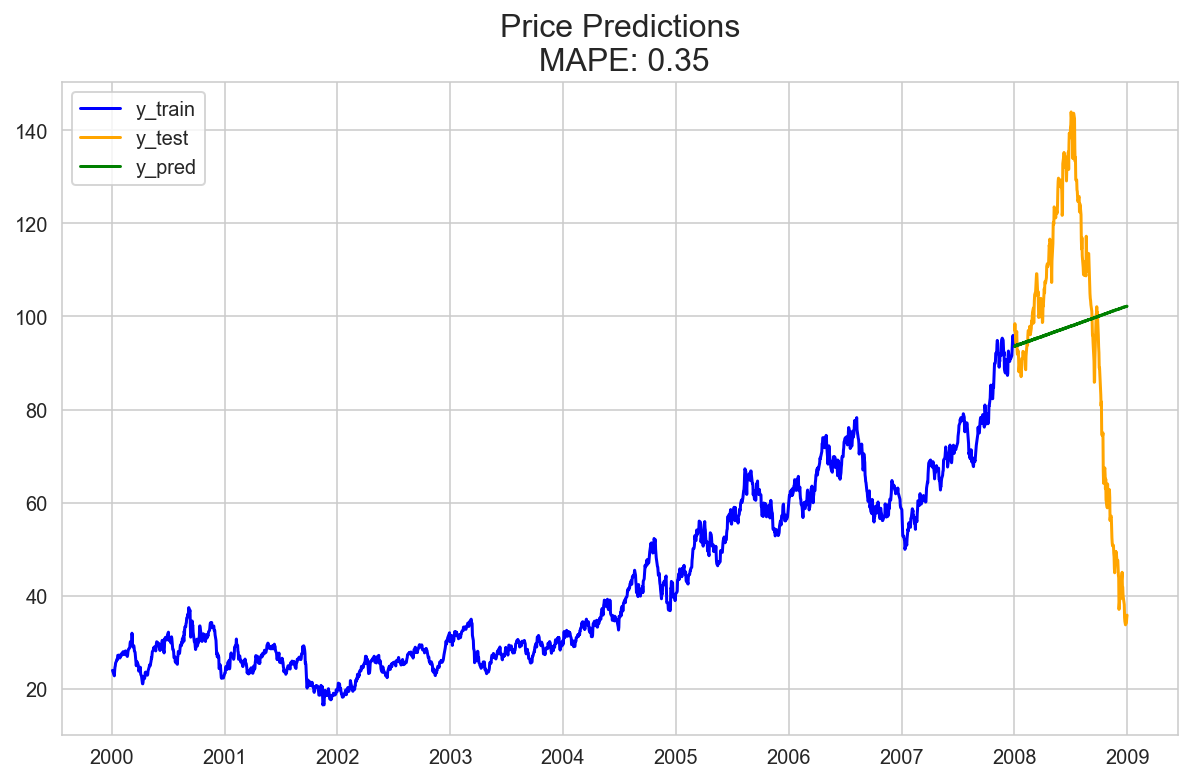

In [63]:
plot_forecast(y_train, y_test, arima_model, X_test=None)

Making prediction on Test set

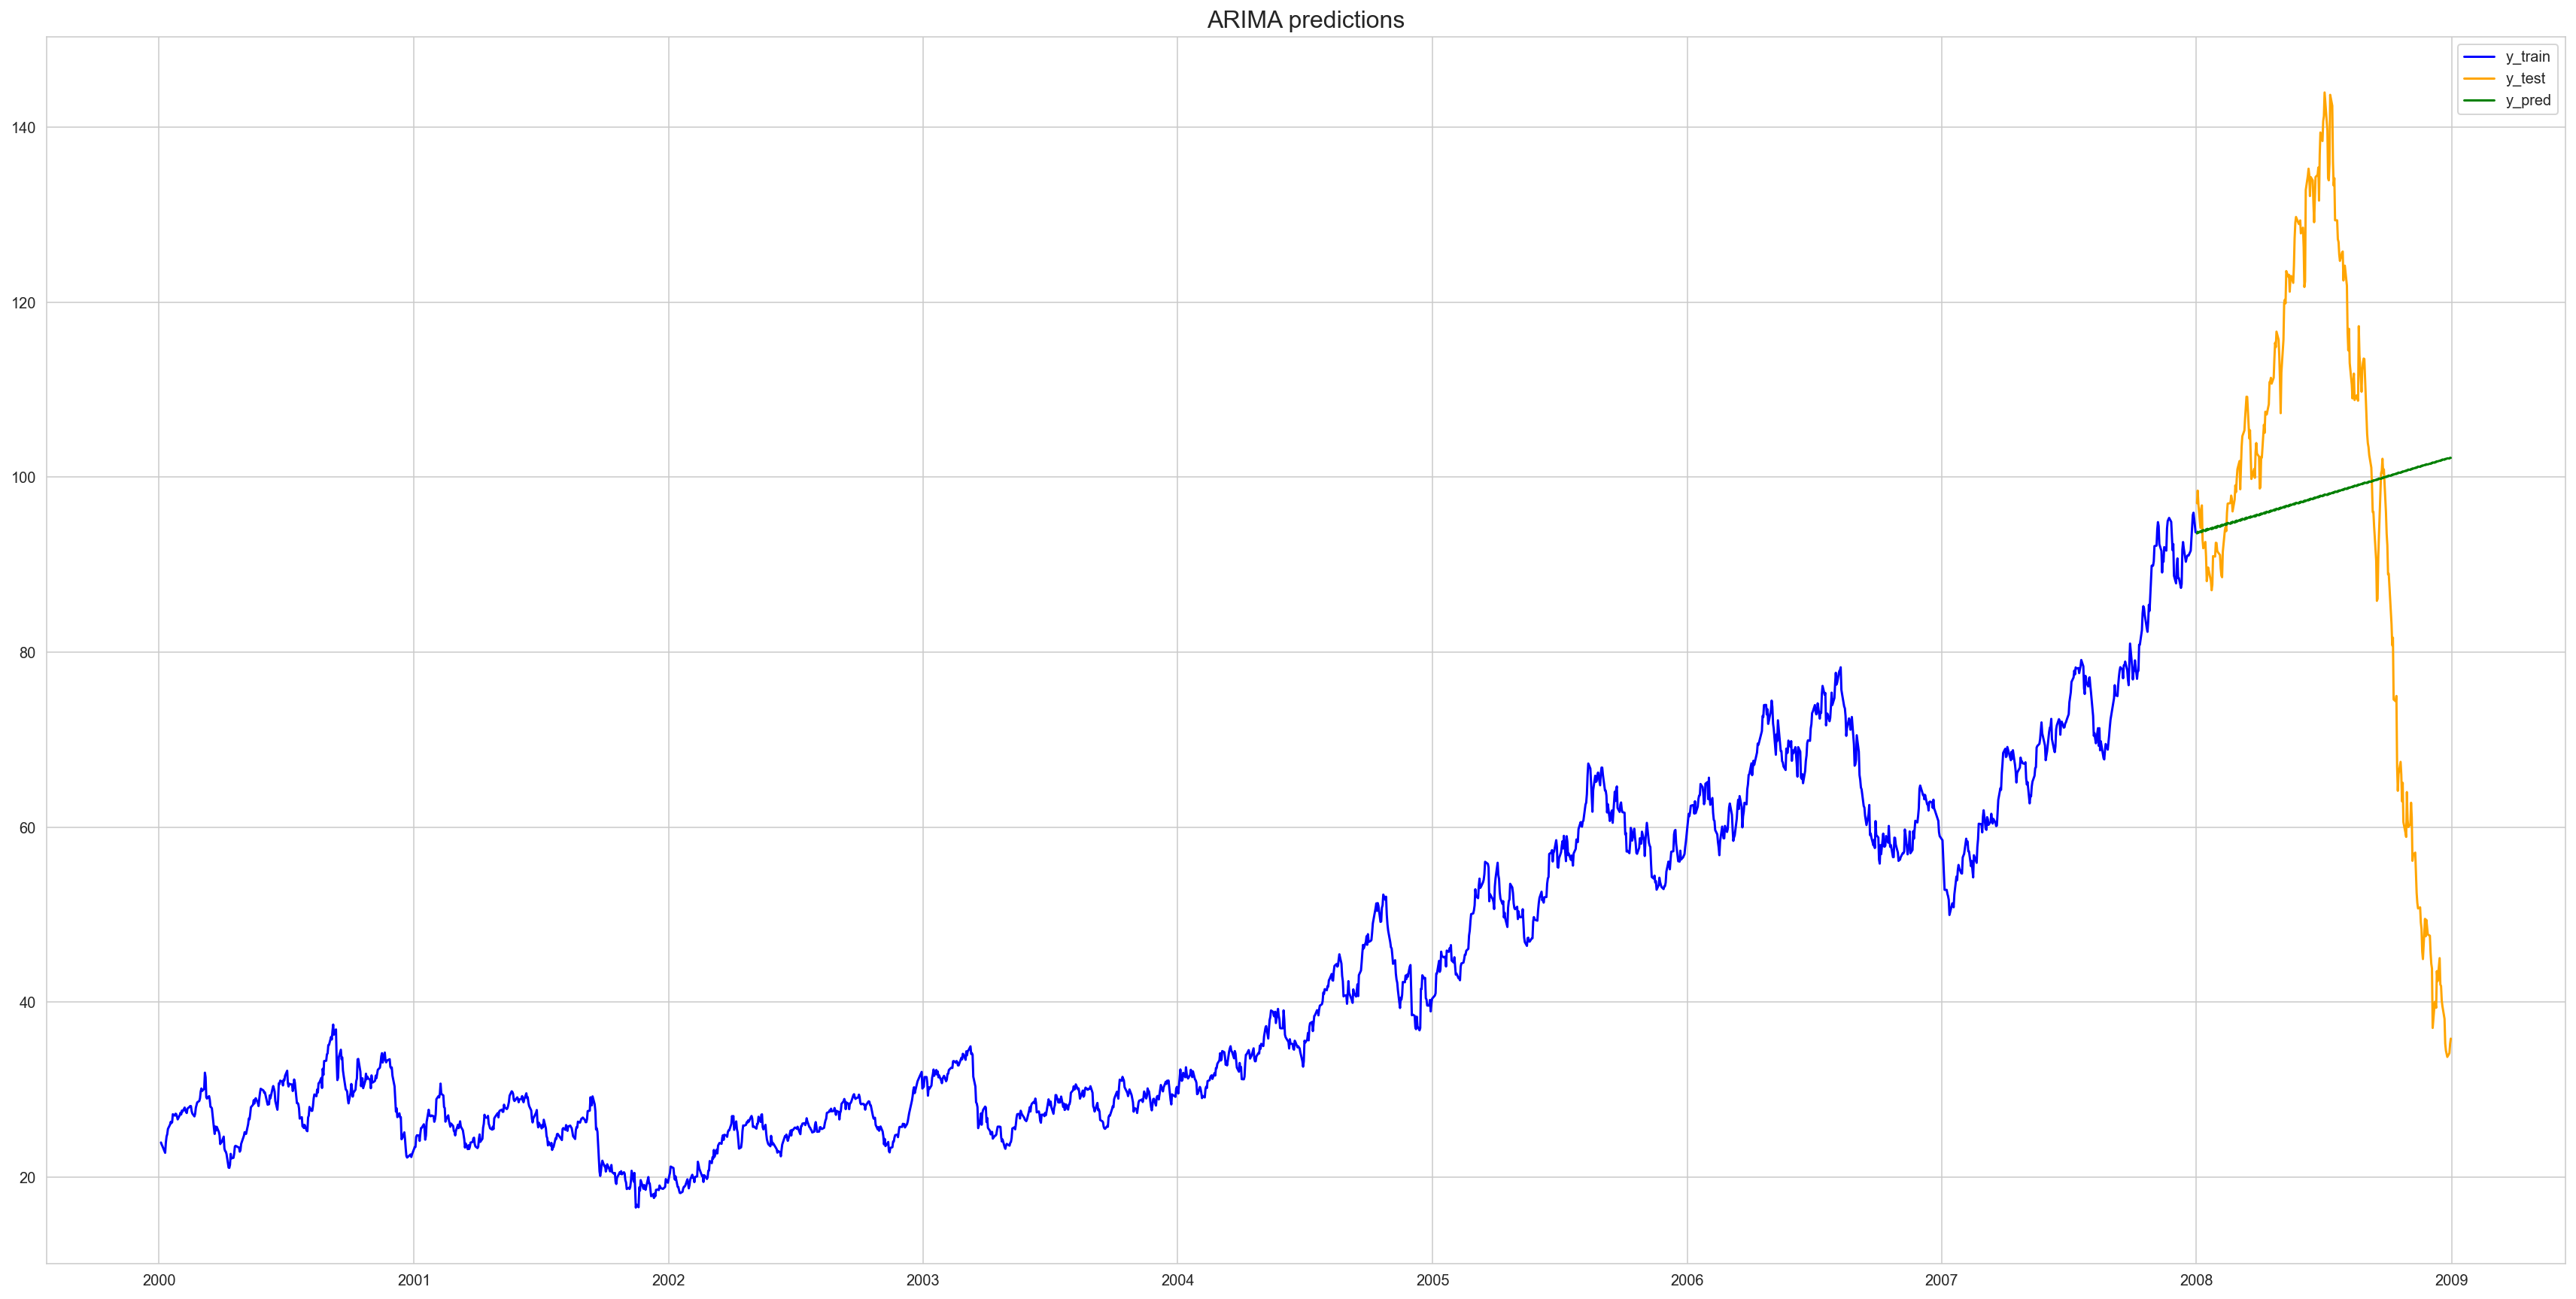

In [59]:
y_pred = arima_model.predict(n_periods = len(y_test))

# Plot data.
plt.figure(figsize=(30,15))

# Plot training data.
plt.plot(y_train, color='blue', label='y_train')

# Plot testing data.
plt.plot(y_test, color='orange', label='y_test')

# Plot predicted test values.
plt.plot(y_test.index, y_pred, color='green', label='y_pred')

plt.title(label = 'ARIMA predictions', fontsize=16)
plt.legend();

4. Setting our variables Function, LSTM

In [64]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = pd.to_datetime(first_date_str)
  last_date  = pd.to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Price'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df


In [65]:
#1987-05-25
windowed_df = df_to_windowed_df(df, 
                                '1987-05-25', 
                                '2022-02-07', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1987-05-25,18.63,18.45,18.55,18.60
1,1987-05-26,18.45,18.55,18.60,18.63
2,1987-05-27,18.55,18.60,18.63,18.60
3,1987-05-28,18.60,18.63,18.60,18.60
4,1987-05-29,18.63,18.60,18.60,18.58
...,...,...,...,...,...
8807,2022-02-01,90.70,91.47,92.35,90.24
8808,2022-02-02,91.47,92.35,90.24,91.43
8809,2022-02-03,92.35,90.24,91.43,92.99
8810,2022-02-04,90.24,91.43,92.99,96.86


Target being corresponding Output and Target -3,2,1 is the input that will fed into our model

In [66]:
def win_df_date_X_y(win_dataframe):
    df_as_np = win_dataframe.to_numpy()
    dates= df_as_np[:,0]
    middle_matrix=df_as_np[:,1:-1]
    X=middle_matrix.reshape((len(dates),middle_matrix.shape[1],1))

    Y=df_as_np[:,-1]
    return dates, X.astype(np.float32),Y.astype(np.float32)

In [67]:
dates, X, y= win_df_date_X_y(windowed_df)

In [68]:
dates.shape, X.shape, y.shape

((8812,), (8812, 3, 1), (8812,))

In [69]:
q_80 = int(len(dates) *.8)
q_90 =int(len(dates) *.9)

dates_train, X_train, y_train = dates[:q_80],X[:q_80],y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90],X[q_80:q_90],y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:],X[q_90:],y[q_90:]

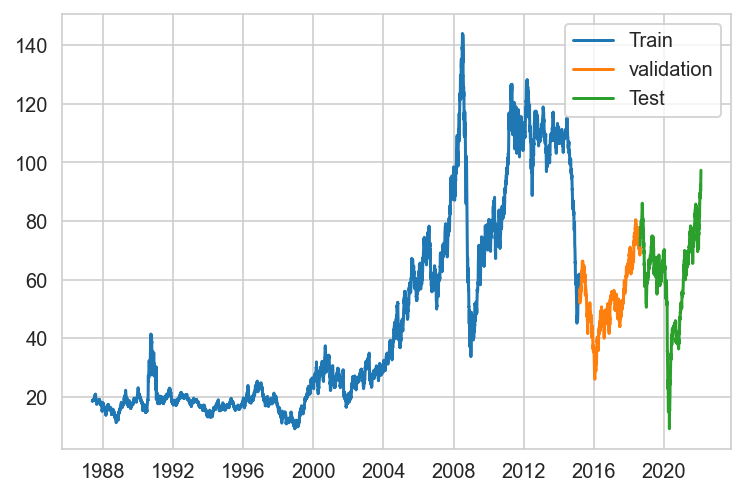

In [70]:
plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)

plt.legend(['Train','validation','Test'])

4.LSTM Model

In [71]:
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [72]:
model= Sequential([layers.Input((3,1)),
                   layers.LSTM(60),
                   layers.Dense(32,activation ='relu'),
                   layers.Dense(32,activation ='relu'),
                   layers.Dense(1)])
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=100, )

Epoch 1/100
221/221 [==============================] - 2s 4ms/step - loss: 1205.9062 - mean_absolute_error: 19.5928 - val_loss: 2.4744 - val_mean_absolute_error: 1.2797
Epoch 2/100
221/221 [==============================] - 1s 2ms/step - loss: 2.5410 - mean_absolute_error: 0.9432 - val_loss: 1.5662 - val_mean_absolute_error: 0.9884
Epoch 3/100
221/221 [==============================] - 1s 3ms/step - loss: 1.6331 - mean_absolute_error: 0.8016 - val_loss: 1.5806 - val_mean_absolute_error: 0.9825
Epoch 4/100
221/221 [==============================] - 1s 3ms/step - loss: 1.5990 - mean_absolute_error: 0.8104 - val_loss: 2.0963 - val_mean_absolute_error: 1.1849
Epoch 5/100
221/221 [==============================] - 1s 3ms/step - loss: 1.5794 - mean_absolute_error: 0.8359 - val_loss: 1.5094 - val_mean_absolute_error: 0.9324
Epoch 6/100
221/221 [==============================] - 1s 3ms/step - loss: 1.5700 - mean_absolute_error: 0.8168 - val_loss: 1.3790 - val_mean_absolute_error: 0.9159
Epoch 

221/221 [==============================] - 1s 2ms/step - loss: 1.3643 - mean_absolute_error: 0.7459 - val_loss: 1.2781 - val_mean_absolute_error: 0.8529
Epoch 100/100
221/221 [==============================] - 1s 3ms/step - loss: 1.2839 - mean_absolute_error: 0.7274 - val_loss: 1.4305 - val_mean_absolute_error: 0.9094


mean_absolute_error this is important

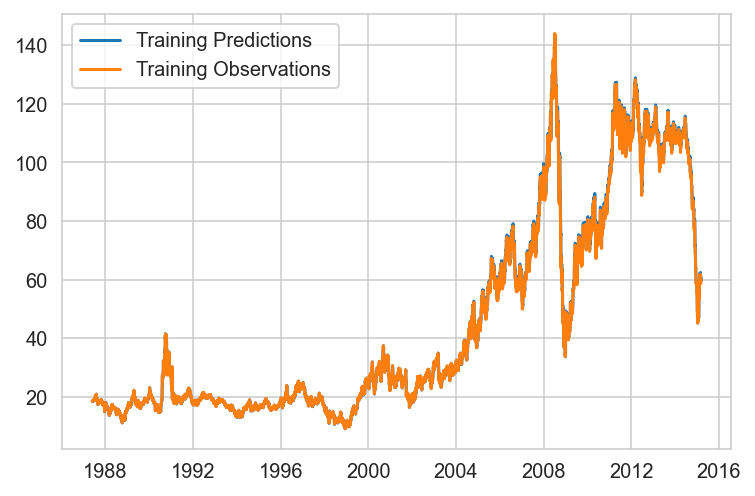

In [74]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

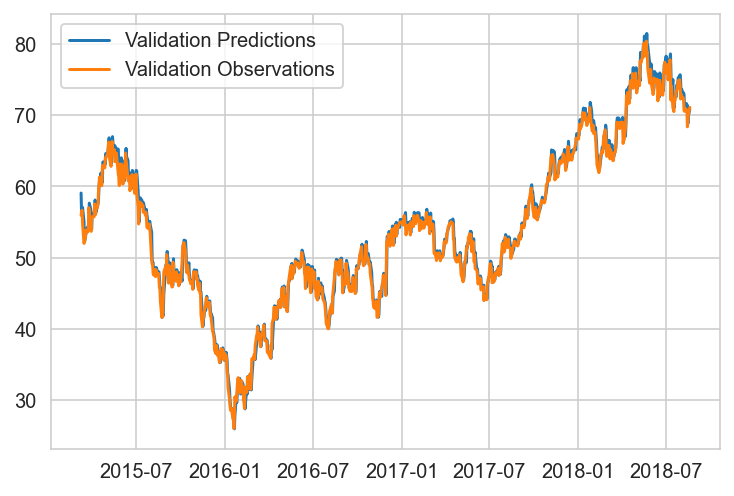

In [75]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

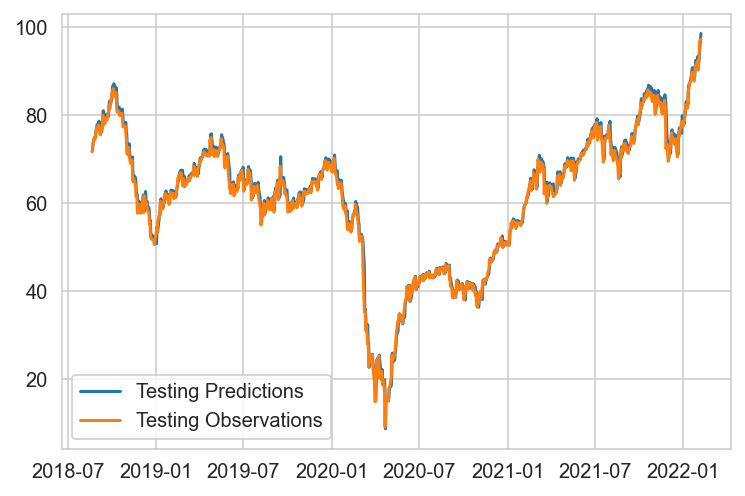

In [76]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

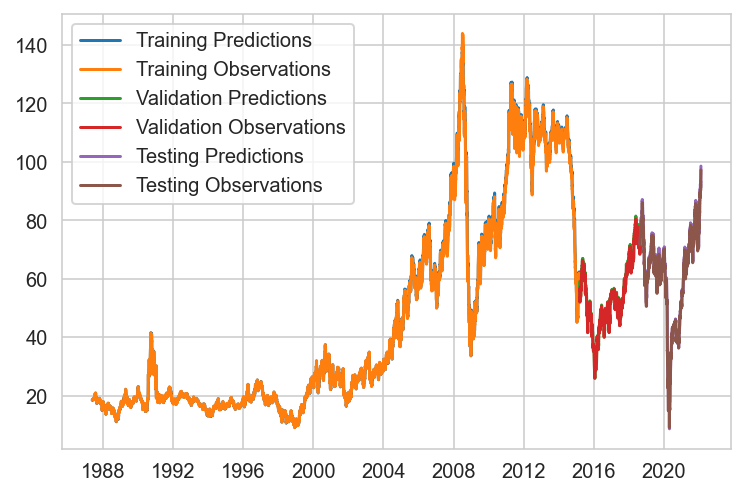

In [77]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [78]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

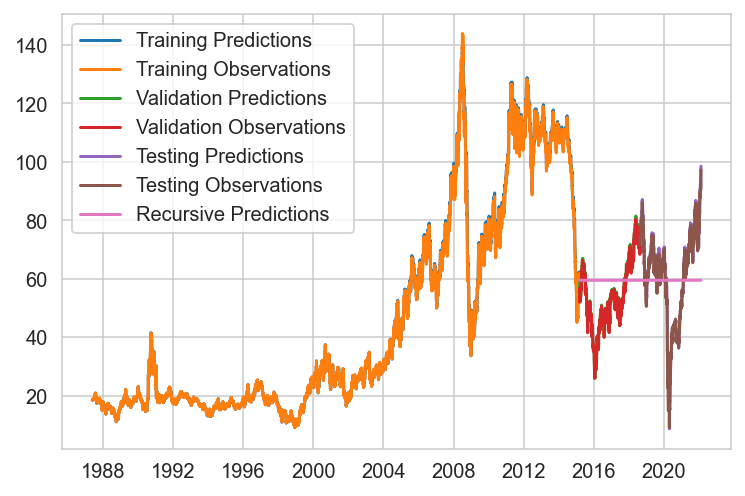

In [79]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])